## TODO


### Imports

In [1]:
import pandas
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [8,5]
np.set_printoptions(suppress=True)

import os
import shutil
from matplotlib.ticker import StrMethodFormatter, NullFormatter
import dictdiffer

from tqdm.notebook import tnrange as nrange
from tqdm.notebook import tqdm

In [2]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pandas.options.display

    display.max_columns = 1000
    display.max_rows = 100
    display.max_colwidth = 199
    display.width = None
    display.float_format = '{:.2f}'.format
    # display.precision = 2  # set as needed
set_pandas_display_options()

In [3]:
path = "E:\\Studium\\10_Semester\\Masterarbeit\\Deployment\\Kafka\\results\\setup"
output = "E:\\Studium\\10_Semester\\Masterarbeit\\Deployment\\Kafka\\eval\\"
experiment = 0
path = path + str(experiment) + os.path.sep
output = output + str(experiment) + os.path.sep

## Filter

In [4]:
def dropFirstXRows(input, x):
    return input.drop(np.arange(0,x))

def removeNaN(array, array2):
    helper = np.logical_not(np.isnan(array))
    return array[helper], array2[helper]

In [5]:
def filterLastData(generated, received):
    lastOffset = received["Kafka.Offset"].to_numpy()[-1]
    return generated[generated["Kafka.Offset"] <= lastOffset]

In [6]:
def loadData(path):
    
    names = []
    produced_generated = []
    produced_recieved = []
    filtered = []
    warnings = []
    modelchange = []
    firstTimestamp = []
    
    runs = [x for x in os.listdir(path)]
    producerByRun = []
    for r in runs:
        pathHelper = path + r + str(os.path.sep) + "data" + str(os.path.sep)
        producer = [pathHelper + x + str(os.path.sep) for x in os.listdir(pathHelper)]
        producerByRun.append(producer)

        for prod in tqdm(producer):
            #print(prod)
            time = os.listdir(prod)[0]
            topic = list(filter(lambda x : len(x) == 6, os.listdir(prod + time + str(os.path.sep))))[0][:-4]
            
            dataPath = prod  + str(os.path.sep) + time + str(os.path.sep) + topic
            
            produced_generated_df = pandas.read_csv(dataPath + "_produced.csv")
            produced_recieved_df = pandas.read_csv(dataPath + ".csv")

            produced_generated_df = filterLastData(produced_generated_df, produced_recieved_df)

            filtered_df = pandas.read_csv(dataPath + "_filtered.csv")
            warnings_df = pandas.read_csv(dataPath + "_warnings.csv")
            modelchange_df = pandas.read_csv(dataPath + "_modelchange.csv")     
            
            #remove first 60100 elements ( around 5 minutes)
            
            modelchange_df = modelchange_df[modelchange_df["producedElements"] > 60101]
            
            producedFilter = produced_generated_df["ProducedElements"] <= 60100 # last point of anomaly
                       
            offsets = produced_generated_df[producedFilter]["Kafka.Offset"].to_numpy()
            produced_generated_df = produced_generated_df[np.logical_not(producedFilter)]

            producedReceivedFilter = np.isin(produced_recieved_df["Kafka.Offset"].to_numpy(), offsets)
            produced_recieved_df = produced_recieved_df[np.logical_not(producedReceivedFilter)]
            
            filteredFilter = np.isin(filtered_df["Data.Offset"].to_numpy(), offsets)
            offsets = filtered_df["Kafka.Offset"][filteredFilter].to_numpy()
            filtered_df = filtered_df[np.logical_not(filteredFilter)]
            
            warningFilter = np.isin(warnings_df["Record.BeginOffset"], offsets)
            warnings_df = warnings_df[np.logical_not(warningFilter)]
            
            firstTimestampValue = produced_generated_df.iloc()[0][3]
            
            produced_generated.append(produced_generated_df)
            produced_recieved.append(produced_recieved_df)
            filtered.append(filtered_df)
            warnings.append(warnings_df)
            modelchange.append(modelchange_df)
            firstTimestamp.append(firstTimestampValue)
            
            names.append("run_" + r + "_" + topic)

    return names, produced_generated, produced_recieved, filtered, warnings, modelchange, firstTimestamp

In [7]:
#load data

names, produced_generated, produced_recieved, filtered, warnings, modelchange, firstTimestamp = loadData(path)

### Helper

In [64]:
def plotDistribution(data, timestamps = None, path = None, firstTimestamp = None):
    
    if timestamps is not None:
        plt.plot((timestamps - firstTimestamp) / 60000, data)
        plt.xlabel("time in min")
        plt.ylabel("duration in ms")
        plt.savefig(path + "_over_time.pdf")
        plt.savefig(path + "_over_time.jpg", dpi = 300)
        plt.close()
    
    
    
    fig, ax = plt.subplots()
    sorted = np.sort(data)
    plt.xscale("log")

    plt.plot(sorted,np.linspace(0, 1,len(sorted),endpoint=True))
    plt.xlabel("duration in ms")
    plt.ylabel("cumulative frequency")
    
    
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    if(path is not None):
        plt.savefig(path + "_dist.pdf")
        plt.savefig(path + "_dist.jpg", dpi = 300)
        plt.close()

In [66]:
def extractAvgMedStdMinMaxFromArray(diff, timestamps, path, name, firstTimestamp):
    plotDistribution(diff, timestamps, path + name, firstTimestamp)
    avg, med, std, minimum, maximum, per90, per95, per99, per99 = (np.average(diff), np.median(diff), np.std(diff), np.min(diff), np.max(diff), np.percentile(diff, 90), np.percentile(diff, 95), np.percentile(diff, 99), np.percentile(diff, 99.9))
    datas = [str(x) for x in [name,avg, med, std, minimum, maximum, per90, per95, per99, per99]]
    file_object = open(path + 'values.csv', 'a')
    file_object.write(";".join(datas) + '\n')
    file_object.close()
    #return "avg = %.2f ms; median %.2f ms; std %.2f ms; min %d ms; max %d ms; 90%% %.2f ms; 95%% %.2f ms; 99%% %.2f ms; 99.9%% %.2f ms"\
    #    %(**datas)
    
def extractAvgMedStdMinMaxFromListOfArray(inputList,path,unit = "ms"):
    diff = np.concatenate(inputList, axis = 0)
    plotDistribution(diff, path = path)
    datas = (np.average(diff), np.median(diff), np.std(diff), np.min(diff), np.max(diff), np.percentile(diff, 90), np.percentile(diff, 95), np.percentile(diff, 99), np.percentile(diff, 99.9))
    text = "avg = %.2f " + unit + "; median %.2f " + unit + "; std %.2f " + unit + "; min %d " + unit + "; max %d " + unit + "; 90%% %.2f " + unit + "; 95%% %.2f " + unit + "; 99%% %.2f " + unit + "; 99.9%% %.2f " + unit
    print(text %(datas))
    return diff

In [10]:
def prepareDictory(path):
    shutil.rmtree(path,ignore_errors=True)
    os.makedirs(path, exist_ok=True)
    file_object = open(path + 'values.csv', 'w')
    file_object.write(";".join(["name", "avg", "med", "std", "minimum", "maximum", "per90", "per95", "per99", "per99"]) + '\n')
    file_object.close()

### Histogram of generated data over time

consumer & produducer timestamp of the produced data

data isn't produced every 5ms instead there are peaks and lows, just the avg is 5ms

In [39]:
def plotHist(data, label, firstTimestamp, width = 250, slabel = False):
    timespan = data[-1] - data[0]
    
    plt.hist((data - firstTimestamp) / 1000, bins = int(timespan / width),zorder=2, label = label)
    plt.hlines(width / 5, 0, (data[-1] - firstTimestamp) / 1000, color = "red", zorder=1, label = "expected amount of points" if slabel else None)
    #plt.title("Gaussian Histogram")
    plt.xlabel("runtime of the experiment in s")
    plt.ylabel("data points in an 250 ms intervall")
    plt.legend()

for x in nrange(len(names)):
    try:
        producedTime = produced_generated[x].to_numpy()[:,3]
        #print("Produced data distribution")
        plotHist(producedTime, "produced data points", firstTimestamp[x], slabel = True) 
        #print("Recieved produced data distribution")
        plotHist(produced_recieved[x].to_numpy()[:,0], "recieved data points", firstTimestamp[x])
        p = output + "produced_hist" + os.path.sep
        os.makedirs(p, exist_ok=True)
        p += names[x]
        plt.savefig(p + ".pdf")
        plt.savefig(p + ".jpg", dpi = 300)
        plt.close()
        print(names[x])
    except Exception as e:
        plt.close()
        print(e)
        print("Error", names[x], x)
        



<ipython-input-39-557cceb29125>:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(p + ".pdf")
<ipython-input-39-557cceb29125>:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(p + ".pdf")
<ipython-input-39-557cceb29125>:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(p + ".jpg", dpi = 300)


run_0_t1
run_0_t4
run_0_t6


<ipython-input-39-557cceb29125>:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(p + ".pdf")


run_0_t5
run_0_t3
run_0_t2
run_0_t7
run_1_t6
run_1_t1
run_1_t3
run_1_t7
run_1_t2


<ipython-input-39-557cceb29125>:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(p + ".pdf")


run_1_t5
run_1_t4
run_2_t4
run_2_t7
run_2_t6


<ipython-input-39-557cceb29125>:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(p + ".pdf")


run_2_t5
run_2_t1


<ipython-input-39-557cceb29125>:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(p + ".pdf")


run_2_t2
run_2_t3



In [12]:
def kafkaAggCount(dataList, index, label, path):
    print("How often aggregates Kafka data for", label)
    counts = []
    for x in range(len(names)):
       counts.append(np.unique(produced_recieved[x].to_numpy()[:,index], return_counts = True)[1])
    a,b = np.unique(np.concatenate(counts, axis = 0), return_counts=True)
    countsSum = np.sum(b)
    np.max(b)
    print("Modus: %d with %.2f%%" %(a[np.where(b == np.max(b))][0], (np.max(b) / countsSum) * 100))
    print("One element with %.2f%%" %((b[np.where(a == 1)][0] / countsSum) * 100))
    extractAvgMedStdMinMaxFromListOfArray(counts, path, "r/s")

kafkaAggCount(produced_recieved, 0, "produced_recieved", output + "produced_records_sub")

How often aggregates Kafka data for produced_recieved
Modus: 2 with 19.13%
One element with 15.11%
avg = 8.95 r/s; median 3.00 r/s; std 14.95 r/s; min 1 r/s; max 295 r/s; 90% 39.00 r/s; 95% 46.00 r/s; 99% 56.00 r/s; 99.9% 95.00 r/s


### Information on the time difference between the arival time of records for all 3 topics

peaks caused by cpu time, it is not regulary produced

In [13]:
def avgMedStdArivalTime(df, column, path, name, firstTimestamp, filterArray = None):
    df = df.to_numpy()[:,column].astype(np.int64)
    diff = df[1:,]-df[:-1,]
    timestamps = df[1:,]
    if filterArray is not None:
        diff = diff[filterArray]
        timestamps = timestamps[filterArray]
    extractAvgMedStdMinMaxFromArray(diff, timestamps, path, name, firstTimestamp)
    return diff
    

currentPath = output + "arivalTimesOfData" + os.path.sep
shutil.rmtree(currentPath,ignore_errors=True)
pathesWithoutSep = [currentPath + "produced_generated", currentPath + "produced_received", currentPath + "filtered", currentPath + "warnings"] 
pathes = [x + os.path.sep for x in pathesWithoutSep]
for x in pathes:
    prepareDictory(x)
    
pro_gen = []
pro_rec = []
fil = []
war = []
    
for x in nrange(len(names)):
    try:
        pro_gen.append(avgMedStdArivalTime(produced_generated[x], 3,pathes[0] + os.path.sep, names[x], firstTimestamp[x]))
        pro_rec.append(avgMedStdArivalTime(produced_recieved[x], 0, pathes[1] + os.path.sep, names[x], firstTimestamp[x]))
        fil.append(avgMedStdArivalTime(filtered[x], 0, pathes[2] + os.path.sep, names[x], firstTimestamp[x]))
        warningFilter = np.logical_not(np.isin(warnings[x]["Record.BeginOffset"].to_numpy(), modelchange[x]["producedElements"].to_numpy())[1:])
        war.append(avgMedStdArivalTime(warnings[x], 0, pathes[3] + os.path.sep, names[x], firstTimestamp[x], warningFilter))
    except Exception as e:
        plt.close()
        print(e)
        print("Error", names[x], x)

print("Arival diff of generated data")
diff = extractAvgMedStdMinMaxFromListOfArray(pro_gen, pathesWithoutSep[0])
print("Percentage of 5ms %.2f" %((np.sum(diff == 5)/len(diff) * 100)))
print("Percentage of 0ms %.2f" %((np.sum(diff == 0)/len(diff) * 100)))
print("Percentage of <=10ms %.2f" %((np.sum(diff <= 10)/len(diff) * 100)))
print("Percentage of >100ms %.2f" %((np.sum(diff > 100)/len(diff) * 100)))
print()
print("Arival diff of generated data from Kafka")
extractAvgMedStdMinMaxFromListOfArray(pro_rec, pathesWithoutSep[1])
print("Arival diff of filtered data from Kafka")
extractAvgMedStdMinMaxFromListOfArray(fil, pathesWithoutSep[2])
print("Arival diff of warning data from Kafka")
_ = extractAvgMedStdMinMaxFromListOfArray(war, pathesWithoutSep[3])


Arival diff of generated data
avg = 5.00 ms; median 5.00 ms; std 3.38 ms; min 0 ms; max 657 ms; 90% 6.00 ms; 95% 7.00 ms; 99% 11.00 ms; 99.9% 23.00 ms
Percentage of 5ms 57.07
Percentage of 0ms 2.64
Percentage of <=10ms 98.93
Percentage of >100ms 0.01

Arival diff of generated data from Kafka
avg = 5.00 ms; median 0.00 ms; std 28.18 ms; min 0 ms; max 1488 ms; 90% 8.00 ms; 95% 19.00 ms; 99% 206.00 ms; 99.9% 266.00 ms
Arival diff of filtered data from Kafka
avg = 5.00 ms; median 0.00 ms; std 33.83 ms; min 0 ms; max 1831 ms; 90% 0.00 ms; 95% 12.00 ms; 99% 221.00 ms; 99.9% 433.00 ms
Arival diff of warning data from Kafka
avg = 26.76 ms; median 0.00 ms; std 73.12 ms; min 0 ms; max 1456 ms; 90% 54.00 ms; 95% 224.00 ms; 99% 350.00 ms; 99.9% 606.50 ms


array([24, 25,  0, ...,  0,  0,  0], dtype=int64)

In [14]:
print("Percentage of 5ms %.2f" %((np.sum(diff == 5)/len(diff) * 100)))
print("Percentage of 0ms %.2f" %((np.sum(diff == 0)/len(diff) * 100)))
print("Percentage of <=10ms %.2f" %((np.sum(diff <= 10)/len(diff) * 100)))
print("Percentage of >100ms %.2f" %((np.sum(diff > 100)/len(diff) * 100)))

Percentage of 5ms 57.07
Percentage of 0ms 2.64
Percentage of <=10ms 98.93
Percentage of >100ms 0.01


## Check Produced

### How long does it take until a produced record is acknowledged by kafka

In [15]:
def kafkaAck(df, path, name, firstTimestamp):
    ack = df.to_numpy()[:,0].astype(np.int64)
    send = df.to_numpy()[:,3].astype(np.int64)
    diff = ack - send
    extractAvgMedStdMinMaxFromArray(diff, send, path, name, firstTimestamp)
    return diff


currentPath = output + "producedAckByKafka"
prepareDictory(currentPath + os.path.sep)

kaf = []

for x in nrange(len(names)):
    try:
        kaf.append(kafkaAck(produced_recieved[x], currentPath + os.path.sep, names[x], firstTimestamp[x]))
    except Exception as e:
        plt.close()
        print(e)
        print("Error", names[x], x)

print("Produced acknowledged by Kafka")
_ = extractAvgMedStdMinMaxFromListOfArray(kaf, currentPath)


Produced acknowledged by Kafka
avg = 166.59 ms; median 151.00 ms; std 119.19 ms; min 1 ms; max 1693 ms; 90% 295.00 ms; 95% 396.00 ms; 99% 515.00 ms; 99.9% 845.00 ms


array([ 99,  93,  87, ..., 236, 231, 349], dtype=int64)

### check validity of produced data

In [16]:
def validate(df, heigherFields, heigherOrEqualFields, offset):
    df = df.to_numpy()#[:,0:4]
    
    lastRow = df[0]
    error = False
    
    for x in df[1:]:
            
        if(np.sum(x[heigherFields] > lastRow[heigherFields]) != len(heigherFields) or 
           np.sum(x[heigherOrEqualFields] >= lastRow[heigherOrEqualFields]) != len(heigherOrEqualFields)):
            error = True
            print("Error:")
            print(lastRow)
            print(x)
        if(not np.sum(lastRow[offset] + 1 == x[offset]) == len(offset)):
            print("Offset %i increased not by 1" %lastRow[2])
            
        lastRow = x
    return not error
        
    #f.value = 100

for x in nrange(len(names)):
    if not validate(produced_recieved[x],[2],[0,1,3],[2]):
        print("Not valid produced", names[x])
    if not validate(filtered[x],[2,3],[0,1,4],[2,3]):
        print("Not valid filtered", names[x])
    if not validate(warnings[x],[2,4,5],[0,1,6,7],[2]):
        print("Not valid warnings", names[x])

### Time between the last step and the next

In [33]:
def extractDiffBetweenTwoTables(a,b,keyA,keyB, sortBy, valueA, valueB):
    joined = a.set_index(keyA).add_prefix('a_').join(b.set_index(keyB).add_prefix('b_'))#.sort_values("b_" + sortBy, ascending = True)

    diff = joined['a_' + valueA].to_numpy() - joined['b_' + valueB].to_numpy()
    return diff, joined['b_' + valueB].to_numpy(), joined

currentPathPF = output + "receivedByFollowingTopic" + os.path.sep + "ProducedFiltered"
prepareDictory(currentPathPF + os.path.sep)
currentPathPPR = output + "receivedByFollowingTopic" + os.path.sep + "ProducedProdRec"
prepareDictory(currentPathPPR + os.path.sep)

diffListPF = []
diffListPPR = []

for x in nrange(len(names)):
    try:
        diffPF, timestamps, _ = extractDiffBetweenTwoTables(filtered[x], produced_recieved[x], 'Data.Offset', 'Kafka.Offset', "Consumer.Time", 'Consumer.Time', 'Consumer.Time')
        extractAvgMedStdMinMaxFromArray(diffPF, timestamps, currentPathPF + os.path.sep, names[x], firstTimestamp[x])
        diffListPF.append(diffPF)
        
        diffPPR, timestamps, _ = extractDiffBetweenTwoTables(produced_recieved[x], produced_generated[x], 'Kafka.Offset', 'Kafka.Offset', "Kafka.Offset", 'Consumer.Time', 'Producer.Timestamp')
        extractAvgMedStdMinMaxFromArray(diffPPR, timestamps, currentPathPPR + os.path.sep, names[x], firstTimestamp[x])
        diffListPPR.append(diffPPR)
    except Exception as e:
        plt.close()
        print(e)
        print("Error", names[x], x)

        
print("Produced -> Produced Received")
extractAvgMedStdMinMaxFromListOfArray(diffListPPR, currentPathPPR)
diffPPR = np.concatenate(diffListPPR, axis = 0)
print("More than 100 ms: %.2f%%"%((np.sum(diffPPR > 100) / len(diffPPR)) * 100))
print("More lower than 8 ms: %.2f%%"%((np.sum(diffPPR < 8) / len(diffPPR)) * 100))

print("Produced -> Filtered")
_ = extractAvgMedStdMinMaxFromListOfArray(diffListPF, currentPathPF)


Produced -> Produced Received
avg = 166.55 ms; median 151.00 ms; std 119.19 ms; min 1 ms; max 1693 ms; 90% 295.00 ms; 95% 396.00 ms; 99% 515.00 ms; 99.9% 845.00 ms
More than 100 ms: 112255.90%
Produced -> Filtered
avg = 178.22 ms; median 155.00 ms; std 161.56 ms; min -1279 ms; max 2277 ms; 90% 365.00 ms; 95% 468.00 ms; 99% 670.00 ms; 99.9% 1171.00 ms


array([254, 254, 254, ..., 161, 161, 161], dtype=int64)

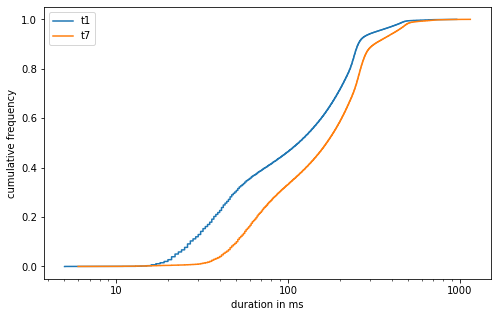

In [80]:
#print two together
def printTwoTogether(combineIds, namesForIds):

    indexes = [names.index(x) for x in combineIds]

    fig, ax = plt.subplots()

    plt.xscale("log")

    for x in range(len(indexes)):
        diffPPR, timestamps, _ = extractDiffBetweenTwoTables(produced_recieved[indexes[x]], produced_generated[indexes[x]], 'Kafka.Offset', 'Kafka.Offset', "Kafka.Offset", 'Consumer.Time', 'Producer.Timestamp')
        #extractAvgMedStdMinMaxFromArray(diffPPR, None, None, None, None)
        sorted = np.sort(diffPPR)
        plt.plot(sorted,np.linspace(0, 1,len(sorted),endpoint=True), label = namesForIds[x])




    plt.xlabel("duration in ms")
    plt.ylabel("cumulative frequency")
    plt.legend()

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.xaxis.set_minor_formatter(NullFormatter())

    cOutput = output + "receivedByFollowingTopic" + os.path.sep + "ProducedProdRec_" + "-".join(combineIds)
    plt.savefig(cOutput + ".jpg", dpi = 300)
    plt.savefig(cOutput + ".pdf")
    plt.show()

printTwoTogether(["run_2_t1", "run_2_t7"], ["t1", "t7"])

Negative values are possible, a node can receive the warnings before the filtered, it depends on the position in cluster an other aspects

In [88]:
currentPathFW = output + "receivedByFollowingTopic" + os.path.sep + "FilteredRecWarning"
prepareDictory(currentPathFW + os.path.sep)

currentPathPW = output + "receivedByFollowingTopic" + os.path.sep + "ProducedRecWarning"
prepareDictory(currentPathPW + os.path.sep)

currentPathPGW = output + "receivedByFollowingTopic" + os.path.sep + "ProducedGenWarning"
prepareDictory(currentPathPGW + os.path.sep)

fw = []
pw = []
pgw = []

for x in nrange(len(names)):
    try:
        
        #In warnings Record.BeginOffset and Record.EndOffset are the related filtered offsets! There is no guarantee that these values are the same!!
        warnings_filtered_joined = warnings[x].set_index("Record.BeginOffset").join(filtered[x].add_prefix('fb_').set_index("fb_Kafka.Offset")).set_index("Record.EndOffset").join(filtered[x].add_prefix('fe_').set_index("fe_Kafka.Offset"))

        diff = (warnings_filtered_joined["Consumer.Time"] - warnings_filtered_joined["fb_Consumer.Time"]).to_numpy()
        diff, timestamps = removeNaN(diff, warnings_filtered_joined["fb_Consumer.Time"].to_numpy())
        extractAvgMedStdMinMaxFromArray(diff, timestamps, currentPathFW + os.path.sep, names[x], firstTimestamp[x])
        fw.append(diff)

        diff, timestamps, prod_warning_join = extractDiffBetweenTwoTables(warnings_filtered_joined, produced_recieved[x].add_prefix('pr_'), 'fb_Data.Offset', 'pr_Kafka.Offset', "pr_Consumer.Time", 'Consumer.Time', 'pr_Consumer.Time')
        diff, timestamps = removeNaN(diff, timestamps)
        extractAvgMedStdMinMaxFromArray(diff, timestamps, currentPathPW + os.path.sep, names[x], firstTimestamp[x])
        pw.append(diff)
        
        prodGenProdRec = produced_generated[x].set_index("Kafka.Offset").join(produced_recieved[x].set_index("Kafka.Offset")).reset_index()
        diff, timestamps, prod_warning_join = extractDiffBetweenTwoTables(warnings_filtered_joined, prodGenProdRec.add_prefix('pr_'), 'fb_Data.Offset', 'pr_Kafka.Offset', "pr_Consumer.Time", 'Consumer.Time', 'pr_Producer.Timestamp')
        diff, timestamps = removeNaN(diff, timestamps)
        extractAvgMedStdMinMaxFromArray(diff, timestamps, currentPathPW + os.path.sep, names[x], firstTimestamp[x])
        pgw.append(diff)
        
    except Exception as e:
        plt.close()
        print(e)
        print("Error", names[x], x)

print("Filtered -> Warning")
extractAvgMedStdMinMaxFromListOfArray(fw, currentPathFW)
print("ProducedRec -> Warning")
_ = extractAvgMedStdMinMaxFromListOfArray(pw, currentPathPW)
print("ProducedGen -> Warning")
_ = extractAvgMedStdMinMaxFromListOfArray(pgw, currentPathPGW)


Filtered -> Warning
avg = 1277.20 ms; median 1142.00 ms; std 901.50 ms; min -427 ms; max 8853 ms; 90% 2479.00 ms; 95% 2941.00 ms; 99% 3878.00 ms; 99.9% 5616.51 ms
ProducedRec -> Warning
avg = 1458.33 ms; median 1325.00 ms; std 909.28 ms; min -244 ms; max 9154 ms; 90% 2666.00 ms; 95% 3126.00 ms; 99% 4117.64 ms; 99.9% 5973.06 ms
ProducedGen -> Warning
avg = 1626.11 ms; median 1501.00 ms; std 906.62 ms; min 52 ms; max 9164 ms; 90% 2816.00 ms; 95% 3275.00 ms; 99% 4269.66 ms; 99.9% 6088.53 ms


In [90]:
diff = np.concatenate(pgw, axis = 0)
print("More than 3000 ms: %.2f%%"%((np.sum(diff > 3000) / len(diff)) * 100))
print("More than 5000 ms: %.2f%%"%((np.sum(diff > 5000) / len(diff)) * 100))

More than 3000 ms: 7.75%
More than 5000 ms: 0.32%


## Data loss produced to filter

In [19]:
def calcDataLoss(df1, df1OffsetColumn, df2, df2OffsetColumn):
    df1Offsets = df1.to_numpy()[:,df1OffsetColumn].astype(np.int64)
    df2Offsets = df2.to_numpy()[:,df2OffsetColumn].astype(np.int64)
    
    errors = {}
        
    count = {}
    
    for x in df1Offsets:
        
        count[x] = 0

        
        #count = np.sum(df2Offsets == x)
        
        #if(count != 1):
        #    errors[count] = errors.get(count, 0) + 1
        
    for x in df1Offsets:
        count[x] = count[x] + 1
        
    for k, v in count.items():
        if v != 1:
            errors[count] = errors.get(count, 0) + 1
    
    out = "Received records "
    losses = False
    for k, v in errors.items():
        out += "%ix for %i times; " %(k,v)
        losses = True
    
    if(losses):
        print(out)
    #else:
    #    print("The expected data was received exactly once.")
    return not losses

for x in nrange(len(names)):
    try:
        
        if not calcDataLoss(produced_generated[x], 0, filtered[x], 3) :
            print("Error", names[x])
        
    except Exception as e:
        plt.close()
        print(e)
        print("Error", names[x], x)
   

## Latency produced - warning

As the filter uses a median filter with size 5 it needs 3 outliers to detect a change. otherwise it is just skipped. ==> there must be a latency of at least (3*5ms) = 15ms

### Check all anomalies were detected

In [20]:
for x in nrange(len(names)):
    try:
        
        filterOver10 = filtered[x][filtered[x]["Data.Measurement"] > 1.0]
        filterOver10Joined = filterOver10.add_prefix('filtered_').set_index("filtered_Kafka.Offset").join(warnings[x].add_prefix('warnings_').set_index("warnings_Record.BeginOffset"))
        noBelongingWarning = filterOver10Joined[filterOver10Joined["warnings_Consumer.Time"].isna()]
        print("Found %d warnings" %(len(filterOver10)))
        if(len(noBelongingWarning) > 0):
            print("%s: For %d / %d anomalies there were no belonging warnings" %(names[x], len(noBelongingWarning),len(filterOver10)))
        
    except Exception as e:
        plt.close()
        print(e)
        print("Error", names[x], x)

Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings
Found 3535 warnings



In [21]:
currentPath = output + "anomalyDetectionTime"
prepareDictory(currentPath + os.path.sep)

diffList = []

for x in nrange(len(names)):
    try:
        
        #received and produced
        pr_rc = produced_generated[x].add_prefix('produced_generated_').set_index("produced_generated_Kafka.Offset").join(produced_recieved[x].add_prefix('produced_recieved_').set_index("produced_recieved_Kafka.Offset")).reset_index()

        #received and produced and filtered
        pr_rc_fi = pr_rc.set_index("produced_generated_Kafka.Offset").join(filtered[x].add_prefix('filtered_').set_index("filtered_Data.Offset")).reset_index()

        #changes and received and produced and filtered
        mc_pg_pr_fi = modelchange[x].add_prefix('modelchange_').set_index("modelchange_producedElements").join(pr_rc_fi.set_index("produced_generated_ProducedElements")).reset_index().rename(columns={'modelchange_producedElements': 'producedElements'})

        #merge all with warnings
        fullJoin = mc_pg_pr_fi.set_index("filtered_Kafka.Offset").join(warnings[x].add_prefix('warning_').set_index("warning_Record.BeginOffset")).reset_index()

        fullJoinOver10 = fullJoin[fullJoin["modelchange_value"] > 1]

        diff = (fullJoinOver10['warning_Consumer.Time'] - fullJoinOver10['produced_generated_Producer.Timestamp']).to_numpy()

        timestamps = fullJoinOver10['produced_generated_Producer.Timestamp'].to_numpy()

        if (np.isnan(diff[-1])):
            diff = diff[:-1]
            timestamps = timestamps[:-1]


        diffList.append(diff)
        extractAvgMedStdMinMaxFromArray(diff, timestamps, currentPath + os.path.sep, names[x], firstTimestamp[x])
        
    except Exception as e:
        plt.close()
        print(e)
        print("Error", names[x], x)

print("Time to detect an anomaly")
_ = extractAvgMedStdMinMaxFromListOfArray(diffList, currentPath)


Time to detect an anomaly
avg = 495.19 ms; median 462.00 ms; std 225.85 ms; min 96 ms; max 2178 ms; 90% 768.40 ms; 95% 874.50 ms; 99% 1222.46 ms; 99.9% 1785.31 ms


array([ 663., 1050.,  167.,  494.,  562.,  144.,  538.,  206.,  572.,
        340.,  519.,  428.,  276.,  484.,  234.,  193.,  394.,  308.,
        299.,  505.,  490., 1008.,  453.,  405.,  334.,  145.,  365.,
        527.,  536.,  178.,  175.,  351.,  276.,  599.,  514., 1238.,
        524.,  321.,  401.,  527.,  373.,  751.,  773.,  713.,  803.,
        792.,  946.,  454.,  641.,  597.,  591.,  773.,  376.,  180.,
        808.,  309.,  683.,  595.,  549., 1202.,  461.,  472., 1028.,
        786.,  347.,  417.,  601.,  666.,  509.,  476., 1034.,  622.,
        636.,  797.,  440.,  304.,  747.,  231., 1319.,  484., 1187.,
        941.,  348.,  386.,  374.,  608.,  596.,  285.,  218.,  223.,
        351.,  754.,  487.,  468.,  739.,  441.,  320.,  359.,  670.,
        377.,  501.,  493.,  584.,  766.,  571.,  744.,  541.,  381.,
        419.,  359., 1128., 1233.,  249.,  579.,  446.,  983.,  445.,
        742.,  448.,  651.,  467.,  443.,  188.,  590.,  458.,  590.,
        732.,  298.,

## Usage

In [22]:
def extractUsage(lines, server, run):
    data = {}

    date = None
    for l in lines:
        if l.startswith("Time "):
            date = int(l[5:-1])
        else:
            e = l.split(' ');
            e = list(filter(lambda x: x != "", e))
            cpu = float(e[0])
            mem = float(e[1])
            pid = int(e[2])
            time = e[3].split(":")
            secondsRunning = int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])
            name = e[4]
            container = e[5]
            up = e[6]
            
            if(name.startswith("etcd")):
                pass
            else:
                split = name.split("_")
                
                if split[1] == "POD":
                    continue
                name = split[1] + "-" +  split[2]
            
            pid_data = data.get(pid, {
                "mem": [],
                "cpu": [],
                "pid" : pid,
                "running" : [],
                "name" : name,
                "container" : container
            })

            pid_data["mem"].append(mem)
            pid_data["cpu"].append(cpu)
            pid_data["running"].append(date)

            data[pid] = pid_data

    zero_cpu = []
    for k in data:
        summ = sum(data[k]["cpu"])
        if summ == 0.0 or data[k]["name"].startswith("debug"):
            zero_cpu.append(k)

    for x in zero_cpu:
        del data[x]

    outpath = output + "usage" + os.path.sep
    
    outpathMem = outpath + "mem" + os.path.sep
    outpathCPU = outpath + "cpu" + os.path.sep

    os.makedirs(outpathMem, exist_ok=True)
    os.makedirs(outpathCPU, exist_ok=True)

    for k in data:
        cpu = data[k]["cpu"]
        running = data[k]["running"]
        plt.plot(running, cpu, label = data[k]["name"][:40])
    plt.legend() 
    plt.ylabel("CPU usage in %")
    #plt.ylim((0,5))
    plt.savefig(outpathCPU + server + "_" + str(run) + ".pdf")
    plt.savefig(outpathCPU + server + "_" + str(run) + ".jpg", dpi = 300)
    #plt.show()
    plt.close()

    for k in data:
        mem = data[k]["mem"]
        running = data[k]["running"]
        plt.plot(running, mem, label = data[k]["name"][:40])
    plt.ylabel("memory usage in %")
    plt.legend()   
    #plt.ylim((0,5))
    plt.savefig(outpathMem + server + "_" + str(run) + ".pdf")
    plt.savefig(outpathMem + server + "_" + str(run) + ".jpg", dpi = 300)
    #plt.show()
    plt.close()

In [23]:
runs = [x for x in os.listdir(path)]

for run in runs:
    p = path + run + os.path.sep + "logs" + os.path.sep + "usage" + os.path.sep
    servers = os.listdir(p)
    for server in tqdm(servers):
        file = open(p + server + os.path.sep + "ps.log", 'r') 
        lines = file.readlines() 
        extractUsage(lines, server, run)

## Responsibilities

shows already the server ID not kafka ID

In [43]:
def addToData(data, topic, current, seconds):
    #empty
    if not current:
        return data
    
    if topic in data:
        cd = data[topic]
        if cd["data"][-1] != current:
            cd["data"].append(current)
            cd["time"].append(seconds)
    else:
        data[topic] = {
            "data" : [current],
            "time" : [seconds]
        }
    
    return data

def showDiff(data):
    for t in data:
        print(t)
        print(data[t]["data"][0]) 
        if len(data[t]["data"]) > 1:
            ld = data[t]["data"][0]
            for x in range(1, len(data[t]["data"])):
                cd = data[t]["data"][x]                
                print("\x1b[31m" + str(list(dictdiffer.diff(ld,cd))) + "\x1b[0m")
                print("Minute %.1f" %(data[t]["time"][x] / 60))
                ld = cd
        print()
        
def replaceKafkaWithNode(c, pods, second):
    result = []
    for x in c:
        d = pods["kafka-" + str(x)]
        index = 0
        for y in range(len(d["time"])):
            if(d["time"][y] > second):
                break
            index = y
        result.append(d["data"][index]["server"])
    return set(result)

def extractResponsibilities(lines):
    
    trial = 0
    seconds = 0
    topic = None
    partitions = None
    kafka = True
    
    data = {}
    pods = {}
    
    current = {}
    
    for line in lines:
        split = list(filter(lambda x : len(x) > 0, line.split(" ")))
        if(line.startswith("Trial ")):
            kafka = True
            trial = int(split[1])
            seconds = int(split[3])
            current = {}
        elif(line.startswith("  topic \"")):
            data = addToData(data, topic, current, seconds)
            topic = split[1][1:-1]
            partitions = int(split[3])
            current = {}
        elif(line.startswith("    partition ")):
            partition = int(split[1][:-1]) 
            leader =  int(split[3][:-1]) 
            replicas = set([int(x) for x in split[5][:-1].split(",")])
            isrs = set([int(x) for x in split[7][:-1].split(",")])
            current[partition] = {
                "leader" : leader,
                "replicas" : replicas,
                "isrs" : isrs
            }
        elif(line.startswith("pod \"debug")):
            data = addToData(data, topic, current, seconds)
        elif(line.startswith("NAME")):
            kafka = False
        elif(not kafka):
            if(line.startswith(("analyst", "filter", "kafka", "producer", "zoo"))):
                pod = split[0]
                state = split[1]
                server = split[2][:-1]
                
                current = {
                    "state" : state,
                    "server": server
                }
                
                if pod in pods:
                    if pods[pod]["data"][-1] != current:
                        pods[pod]["data"].append(current)
                        pods[pod]["time"].append(seconds)
                else:
                    pods[pod] = {
                        "data" : [current],
                        "time" : [seconds]
                    }
                
            else:
                print("Error", line)
            
    for t in data:
        for i in range(len(data[t]["data"])):
            c = data[t]["data"][i]
            time = data[t]["time"][i]
            for partition in c:
                
                c[partition]["replicas"] = replaceKafkaWithNode(c[partition]["replicas"], pods, time)
                c[partition]["isrs"] = replaceKafkaWithNode(c[partition]["isrs"], pods, time)
                c[partition]["leader"] = list(replaceKafkaWithNode([c[partition]["leader"]], pods, 0))[0]
               
    showDiff(data)
    
    for i in range(5):
        print("====================================")
        
    showDiff(pods)
    
    for i in range(5):
        print("====================================")

runs = os.listdir(path)
for run in runs:    
    print("\x1b[34mRUN:" + str(run) + "\x1b[0m")
    p = path + run + os.path.sep + "logs" + os.path.sep + "responsibilities.log"
    file = open(p, 'r') 
    lines = file.readlines()
    extractResponsibilities(lines)

RUN:0
t4
{0: {'leader': 'server7', 'replicas': {'server7', 'server5', 'server4'}, 'isrs': {'server7', 'server5', 'server4'}}}

t5
{0: {'leader': 'server4', 'replicas': {'server7', 'server4', 'server3'}, 'isrs': {'server7', 'server4', 'server3'}}}

t4_filtered
{0: {'leader': 'server4', 'replicas': {'server1', 'server5', 'server4'}, 'isrs': {'server1', 'server5', 'server4'}}}

t2_filtered
{0: {'leader': 'server5', 'replicas': {'server5', 'server2', 'server4'}, 'isrs': {'server5', 'server2', 'server4'}}}

t7_warnings
{0: {'leader': 'server6', 'replicas': {'server6', 'server2', 'server4'}, 'isrs': {'server6', 'server2', 'server4'}}}

t1_filtered
{0: {'leader': 'server5', 'replicas': {'server5', 'server2', 'server6'}, 'isrs': {'server5', 'server2', 'server6'}}}

t3
{0: {'leader': 'server5', 'replicas': {'server7', 'server5', 'server3'}, 'isrs': {'server7', 'server5', 'server3'}}}

t6
{0: {'leader': 'server4', 'replicas': {'server1', 'server5', 'server4'}, 'isrs': {'server1', 'server5', 'ser